In [60]:
%config Completer.use_jedi = False
from pymongo import MongoClient
import pandas as pd
import datetime as dt
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

client = MongoClient('localhost', 27017)
db = client.resilient

# r/all Analysis

## Connecting to the r/all comment collection.

In [2]:
all_comments = db.all

## Total number of comments.

In [3]:
table = pd.DataFrame.from_dict({
    'Comments': all_comments.estimated_document_count()
}, orient='index')
table.columns = ['N']

display(table)

,N
Comments,41600000


## Number of comments per author.

In [31]:
# Warning: This cell takes a while to compute (~4 minutes for 40M comments.)
all_comments_per_author = pd.DataFrame(all_comments.aggregate([
    {'$project': {'_id': 1, 'author': 1}}, # Only using author field.
    {'$group': {'_id': '$author', 'num_comments': {'$sum': 1}}},
    {'$sort': {'num_comments': -1}} # Sort descending.
], allowDiskUse=True)).rename(columns={'_id': 'author'})

display(all_comments_per_author)

,author,num_comments
0,AutoModerator,1371015
1,FMKBot,125596
2,MangaDexStatsBot2,48612
3,KickOpenTheDoorBot,22352
4,QualityVote,18552
...,...,...
5330184,zzzzzzrink,1
5330185,zzzzzzwhat,1
5330186,zzzzzzzt,1
5330187,zzzzzzzzz301,1


## Number of comments per subreddit.

In [32]:
# Warning: This cell takes a while to compute (~4 minutes for 40M comments.)
all_comments_per_subreddit = pd.DataFrame(all_comments.aggregate([
    {'$project': {'_id': 1, 'subreddit': 1}},
    {'$group': {'_id': '$subreddit', 'num_comments': {'$sum': 1}}},
    {'$sort': {'num_comments': -1}}
], allowDiskUse=True)).rename(columns={'_id': 'author'})

display(all_comments_per_subreddit)

,subreddit,num_comments
0,AskReddit,1270175
1,teenagers,472115
2,worldnews,450123
3,Eldenring,439897
4,AmItheAsshole,390762
...,...,...
159651,poex,1
159652,Mode_Earn_App,1
159653,anthropocenereviewed,1
159654,u_Wonderingslayer,1


## Number of comments per hour for specific subreddit.

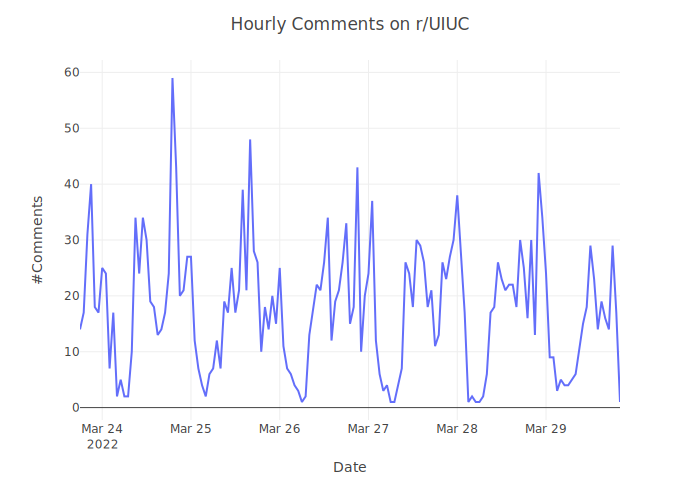

In [26]:
subreddit = 'UIUC'

selected_comments = pd.DataFrame(
    all_comments.find({'subreddit': {'$eq': 'UIUC'}})
)

daily = pd.to_datetime(selected_comments['created_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central') \
    .round('H') \
    .value_counts() \
    .sort_index()

fig = px.line(daily)

fig.update_layout(
    template='none',
    showlegend=False,
    xaxis_title='Date',
    yaxis_title='#Comments',
    title=f'Hourly Comments on r/{subreddit}'
)

fig.show('svg')

# r/popular Analysis

## Connecting to r/popular snapshots collection.

In [27]:
popular_snapshots = db.popular

## Grouping r/popular thread IDs, identifying their subreddit, and listing their snapshots (along with snapshot attributes).

Each thread should come with their first timestamp (`min_utc`), last timestamp (`max_utc`), and the number of seconds in between known as the thread's lifespan (`lifespan`).

In [30]:
popular_threads = pd.DataFrame(popular_snapshots.aggregate([
    {'$sort': {'retrieved_utc': 1}},
    {'$group': {'_id': '$id',
                'subreddit': {'$first': '$subreddit'},
                'created_utc': {'$first': '$created_utc'},
                'num_snapshots': {'$sum': 1},
                'max_utc': {'$max': '$retrieved_utc'},
                'min_utc': {'$min': '$retrieved_utc'},
                'snapshots': {'$push': 
                              {'retrieved_utc': '$retrieved_utc',
                               'rank': '$rank',
                               'score': '$score',
                               'upvote_ratio': '$upvote_ratio',
                               'num_comments': '$num_comments'}}}},
    {'$sort': {'num_snapshots': -1}}
], allowDiskUse=True)).rename(columns={'_id': 'id'})

popular_threads['datetime'] = \
    pd.to_datetime(popular_threads['created_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central')

popular_threads['max_datetime'] = \
    pd.to_datetime(popular_threads['max_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central')

popular_threads['min_datetime'] = \
    pd.to_datetime(popular_threads['min_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central')

popular_threads['created_to_popular'] = popular_threads['min_utc'] - popular_threads['created_utc']

popular_threads['popular_window'] = popular_threads['max_utc'] - popular_threads['min_utc']

# Active window for comments, i.e., first comment UTC to last comment UTC.

display(popular_threads)

,id,subreddit,created_utc,num_snapshots,max_utc,min_utc,snapshots,datetime,max_datetime,min_datetime,created_to_popular,popular_window
0,too3mu,cringepics,1.648300e+09,609,1648383475,1648309167,"[{'retrieved_utc': 1648309167, 'rank': 99, 'sc...",2022-03-26 08:05:20-05:00,2022-03-27 07:17:55-05:00,2022-03-26 10:39:27-05:00,9247.0,74308
1,tnktby,gadgets,1.648211e+09,595,1648295736,1648223150,"[{'retrieved_utc': 1648223150, 'rank': 96, 'sc...",2022-03-25 07:27:13-05:00,2022-03-26 06:55:36-05:00,2022-03-25 10:45:50-05:00,11917.0,72586
2,toak5d,CollegeBasketball,1.648258e+09,568,1648328241,1648258960,"[{'retrieved_utc': 1648258960, 'rank': 57, 'sc...",2022-03-25 20:26:04-05:00,2022-03-26 15:57:21-05:00,2022-03-25 20:42:40-05:00,996.0,69281
3,tq5q3y,educationalgifs,1.648461e+09,568,1648541576,1648472236,"[{'retrieved_utc': 1648472236, 'rank': 97, 'sc...",2022-03-28 04:50:39-05:00,2022-03-29 03:12:56-05:00,2022-03-28 07:57:16-05:00,11197.0,69340
4,tofiar,Music,1.648264e+09,557,1648334847,1648266912,"[{'retrieved_utc': 1648266912, 'rank': 84, 'sc...",2022-03-25 22:05:30-05:00,2022-03-26 17:47:27-05:00,2022-03-25 22:55:12-05:00,2982.0,67935
...,...,...,...,...,...,...,...,...,...,...,...,...
2882,tou48y,funny,1.648310e+09,1,1648330443,1648330443,"[{'retrieved_utc': 1648330443, 'rank': 76, 'sc...",2022-03-26 10:53:55-05:00,2022-03-26 16:34:03-05:00,2022-03-26 16:34:03-05:00,20408.0,0
2883,tow4we,relationship_advice,1.648312e+09,1,1648327140,1648327140,"[{'retrieved_utc': 1648327140, 'rank': 96, 'sc...",2022-03-26 11:22:26-05:00,2022-03-26 15:39:00-05:00,2022-03-26 15:39:00-05:00,15394.0,0
2884,tp0r43,shitposting,1.648322e+09,1,1648341694,1648341694,"[{'retrieved_utc': 1648341694, 'rank': 99, 'sc...",2022-03-26 14:21:37-05:00,2022-03-26 19:41:34-05:00,2022-03-26 19:41:34-05:00,19197.0,0
2885,tq8kby,technicallythetruth,1.648472e+09,1,1648481520,1648481520,"[{'retrieved_utc': 1648481520, 'rank': 96, 'sc...",2022-03-28 07:49:19-05:00,2022-03-28 10:32:00-05:00,2022-03-28 10:32:00-05:00,9761.0,0


## Aggregating r/popular threads per subreddit to provide descriptive measures.

In [33]:
popular_subreddits = popular_threads.groupby('subreddit') \
    .agg({'popular_window': 'mean',
          'id': 'count',
          'num_snapshots': 'sum',
          'created_to_popular': 'mean'}) \
    .rename(columns={'id': 'num_threads', 'popular_window': 'average_popular_window'}) \
    .astype(int) \
    .sort_values(by='num_threads', ascending=False)

display(popular_subreddits)

,average_popular_window,num_threads,num_snapshots,created_to_popular
subreddit,,,,
memes,9733,60,4548,11202
worldnews,16684,55,7227,14100
shitposting,10176,54,4304,11557
interestingasfuck,15996,53,6538,13042
MadeMeSmile,15146,49,5797,12905
...,...,...,...,...
MomForAMinute,53899,1,442,19499
hmmm,733,1,7,21434
MemeVideos,8063,1,47,13286


## For a specific r/popular thread, graph it's rank trajectory.

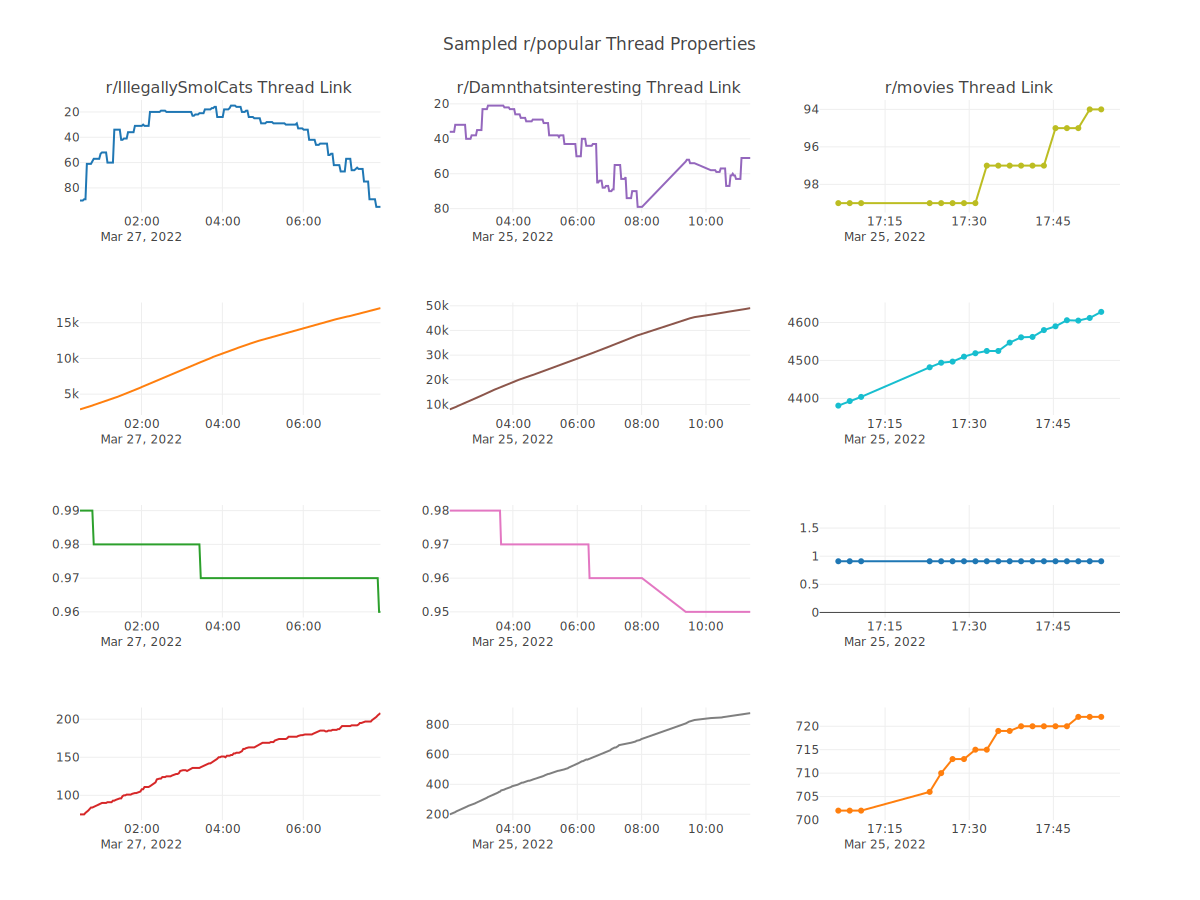

In [189]:
condition = pd.to_datetime(popular_threads['max_utc'], unit='s') \
    < (dt.datetime.now() - dt.timedelta(days=2))

sampled_threads = popular_threads[condition].sample(n=3)
sampled_snapshots = [pd.DataFrame(snapshots) for snapshots in sampled_threads['snapshots']]

titles = [
    f'<a href="https://reddit.com/{thread.id}">r/{thread.subreddit} Thread Link</a>'
    for thread in sampled_threads.itertuples()
]

fig = make_subplots(rows=4, cols=3,
                   subplot_titles=(titles[0], titles[1], titles[2], '',
                                   '', '', '', '',
                                   '', '', '', ''))

for col, snapshots in enumerate(sampled_snapshots):
    
    snapshots['datetime'] = pd.to_datetime(snapshots['retrieved_utc'], unit='s') \
        .dt.tz_localize('UTC') \
        .dt.tz_convert('US/Central')
    
    for row, column in enumerate(['rank', 'score', 'upvote_ratio', 'num_comments']):
        fig.add_trace(
            go.Scatter(x=snapshots['datetime'], y=snapshots[column]),
            row=row+1, col=col+1
        )
    
    fig.update_yaxes(autorange='reversed', zeroline=False,
                     row=1, col=col+1)
        
fig.update_layout(
    template='none',
    height=900,
    width=1200,
    showlegend=False,
    title=f'Sampled r/popular Thread Properties'
)

fig.show('svg')

## Number of r/popular threads on the feed for a specific subreddit.

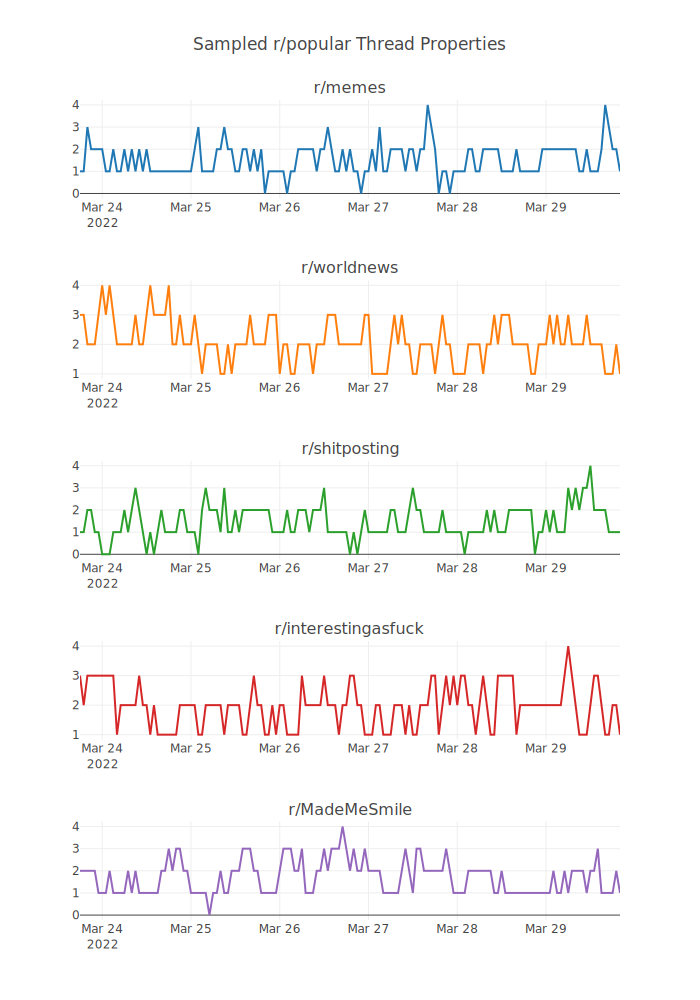

In [210]:
subreddits = ['memes', 'worldnews', 'shitposting', 'interestingasfuck', 'MadeMeSmile']

fig = make_subplots(rows=len(subreddits), subplot_titles=tuple([
    f'<a href="https://reddit.com/r/{subreddit}">r/{subreddit}</a>'
    for subreddit in subreddits
]))

for row, subreddit in enumerate(subreddits):
    
    popular_ranges = popular_threads[popular_threads['subreddit'] == subreddit] \
        [['min_datetime', 'max_datetime']]
    popular_ranges['start_hour'] = popular_ranges['min_datetime'].dt.round('H')
    popular_ranges['end_hour'] = popular_ranges['max_datetime'].dt.round('H')
    
    start = popular_ranges['start_hour'].min()
    end = popular_ranges['end_hour'].max()
    
    date_index = pd.date_range(start, end , freq='H')
    
    count = pd.DataFrame(index=date_index,
                        columns=['num_popular'],
                        data=[0 for _ in range(len(date_index))])
    
    for thread in popular_ranges.itertuples():
        for hour in pd.date_range(thread.start_hour, thread.end_hour, freq='H'):
            count.loc[hour] += 1
            
            
    fig.add_trace(
        go.Scatter(x=count.index, y=count['num_popular']),
        row=row+1, col=1
    )
    
fig.update_layout(
    template='none',
    showlegend=False,
    height=200*len(subreddits),
    title=f'Sampled r/popular Thread Properties'
)
    
fig.show('svg')